## This file contains rnn architecture to train on pc

In [8]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import stft
import os
from matplotlib import pyplot as plt

FRAME_LENGTH = 1024
HOP_LENGTH = 512
SR = 44100
NUM_FRAMES = 31
TARGET_FRAME_INDEX = NUM_FRAMES // 2
FREQ_BINS = FRAME_LENGTH // 2 + 1

def load_audio_with_scipy(file_path, target_sr=SR, frame_length=10 * SR):
    file_path = file_path.numpy().decode("utf-8")
    sr, audio = wavfile.read(file_path)
    if audio.dtype == np.int16:
        audio = audio / 32768.0
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    if sr != target_sr:
        from scipy.signal import resample
        audio = resample(audio, int(len(audio) * target_sr / sr))
    if len(audio) < frame_length:
        audio = np.pad(audio, (0, frame_length - len(audio)), mode='constant')
    else:
        audio = audio[:frame_length * 12]
    return audio

def compute_spectrogram(audio, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH):
    _, _, Zxx = stft(audio, fs=SR, nperseg=frame_length, noverlap=frame_length - hop_length)
    return np.abs(Zxx)

def create_binary_mask(vocal_spec, mix_spec, threshold=1.05):
    return (vocal_spec > threshold * mix_spec).astype(np.int32)

def get_window_from_spectrogram(spectrogram, start_idx, num_frames=NUM_FRAMES):
    num_freq_bins, num_time_frames = spectrogram.shape
    window = np.zeros((num_freq_bins, num_frames))

    start = max(0, start_idx)
    end = min(start_idx + num_frames, num_time_frames)

    insert_start = max(0, -start_idx)
    insert_end = insert_start + (end - start)

    window[:, insert_start:insert_end] = spectrogram[:, start:end]

    return window

def preprocess_pair_with_scipy(mix_path, vocal_path):
    mix_audio = load_audio_with_scipy(mix_path)
    vocal_audio = load_audio_with_scipy(vocal_path)

    mix_spec = compute_spectrogram(mix_audio)
    vocal_spec = compute_spectrogram(vocal_audio)
    mask = create_binary_mask(vocal_spec, mix_spec)

    X, y = [], []
    for i in range(-(NUM_FRAMES // 2), mix_spec.shape[1] - (NUM_FRAMES // 2)):
        window = get_window_from_spectrogram(mix_spec, i, NUM_FRAMES)
        target_frame = mask[:, max(0, min(i + TARGET_FRAME_INDEX, mask.shape[1] - 1))]
        X.append(window)
        y.append(target_frame)
    return np.array(X), np.array(y)

def tf_preprocess(mix_path, vocal_path):
    X, y = tf.py_function(
        func=preprocess_pair_with_scipy,
        inp=[mix_path, vocal_path],
        Tout=[tf.float32, tf.float32],
    )
    X.set_shape([None, FREQ_BINS, NUM_FRAMES])
    y.set_shape([None, FREQ_BINS])
    return X, y


mix_files = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train')]
vocal_files = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/train')]
mix_files.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[:30]])
vocal_files.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[:30]])

mix_files_test = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][:25]
vocal_files_test = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][:25]
mix_files_test.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[30:40]])
vocal_files_test.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[30:40]])

mix_files_validation = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/mixture.wav'
               for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][25:]
vocal_files_validation = [f'drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test/{track}/vocals.wav'
                for track in os.listdir('drive/MyDrive/Colab Notebooks/data/musdb/musdb18hq/test')][25:]
mix_files_validation.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/mix.wav'
                    for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[40:]])
vocal_files_validation.extend([f'drive/MyDrive/Colab Notebooks/data/ccmixter_corpus/{track}/source-02.wav'
                     for track in os.listdir('drive/MyDrive/Colab Notebooks/data/ccmixter_corpus')[40:]])

file_dataset = tf.data.Dataset.from_tensor_slices((mix_files, vocal_files))
file_dataset_test = tf.data.Dataset.from_tensor_slices((mix_files_test, vocal_files_test))
file_dataset_validation = tf.data.Dataset.from_tensor_slices((mix_files_validation, vocal_files_validation))

train_dataset = file_dataset.map(tf_preprocess)
test_dataset = file_dataset_test.map(tf_preprocess)
valid_dataset = file_dataset_validation.map(tf_preprocess)

BATCH_SIZE = 32
epochs=20
train_dataset = train_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset = valid_dataset.unbatch().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [16]:
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
def extract_central_frame(x):
    return x[:, TARGET_FRAME_INDEX, :]

def rnn_model(input_shape=(FREQ_BINS, NUM_FRAMES)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Permute((2, 1))(inputs)

    x = layers.LSTM(256, return_sequences=True, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(256, return_sequences=True, activation='sigmoid')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.TimeDistributed(layers.Dense(FREQ_BINS, activation='sigmoid'))(x)

    outputs = layers.Lambda(extract_central_frame)(x)

    model = Model(inputs, outputs)
    return model

In [18]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

model = rnn_model(input_shape=(FREQ_BINS, NUM_FRAMES))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=["accuracy", 'binary_crossentropy']
)

# Callbacks
checkpoint = ModelCheckpoint("models/best_rnn_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)

epochs = 2

In [19]:
history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    steps_per_epoch=35,
    validation_steps=9,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 40s 855ms/step - accuracy: 0.0011 - binary_crossentropy: 0.6726 - loss: 0.6726 - val_accuracy: 0.0000e+00 - val_binary_crossentropy: 0.5347 - val_loss: 0.5347
Epoch 2/2
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.0018 - binary_crossentropy: 0.5559 - loss: 0.5559 - val_accuracy: 0.0000e+00 - val_binary_crossentropy: 0.4617 - val_loss: 0.4617


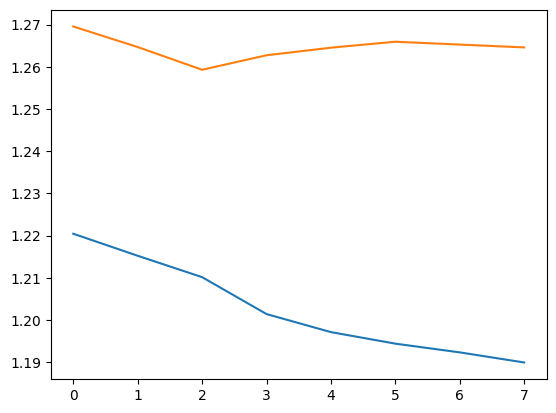

In [21]:
from matplotlib import pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

In [18]:
print(history.history['loss'])
print(history.history['val_loss'])

[1.2206701040267944, 1.2153739929199219, 1.2100173234939575, 1.2011371850967407, 1.196953296661377]
[1.2702150344848633, 1.2633880376815796, 1.2580972909927368, 1.2617402076721191, 1.2641927003860474]
